Acknowledgement: 

Tensorflow 2 official tutorial https://www.tensorflow.org/tutorials/images/transfer_learning

CS231n course website https://cs231n.github.io/

# Prepare environment

Colab is a free tool for experimentation for your project. 
Colab will disconnect after 12 hours or ~30 min of idling (and you will lose your unsaved data). So let's mount to your Google drive first.

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.

# this downloads the CIFAR-100 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/MyDrive
!mkdir ECE209_2021F
%cd ECE209_2021F
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xzvf cifar-100-python.tar.gz
!rm cifar-100-python.tar.gz

In [4]:
import os
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa
import numpy as np
import tensorflow_hub as hub
import random
import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 1.1 MB 4.2 MB/s 


# Colab users

If you are using Colab, you can manually switch to a GPU device in tf.device(device) scope.

In [5]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
  device = '/device:GPU:0'
else:
  device = '/cpu:0'

print('Using device: ', device)

Using device:  /device:GPU:0


# Data

Load CIFAR-100 dataset for training

In [6]:
from six.moves import cPickle as pickle
import numpy as np
import os
from matplotlib.pyplot import imread
import platform

def load_pickle(f):
  version = platform.python_version_tuple()
  if version[0] == '2':
      return  pickle.load(f)
  elif version[0] == '3':
      return  pickle.load(f, encoding='latin1')
  raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['coarse_labels']
    X = X.reshape(len(X), 3, 32, 32).transpose(0,2,3,1).astype("float") #change to uint8 while plotting image
    Y = np.array(Y)
    return X, Y

def load_CIFAR100(ROOT):
  """ load all of cifar """
  Xtr, Ytr = load_CIFAR_batch(os.path.join(ROOT, 'train'))
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test'))
  return Xtr, Ytr, Xte, Yte

# Q1

large_omnivores_and_herbivores


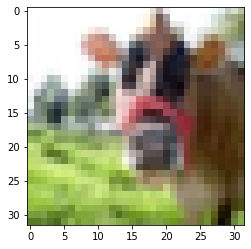

reptiles


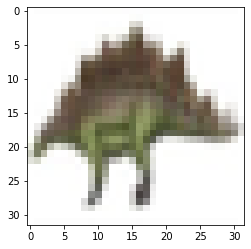

fruit_and_vegetables


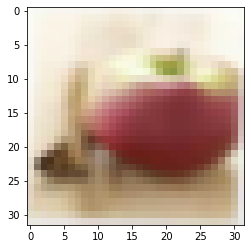

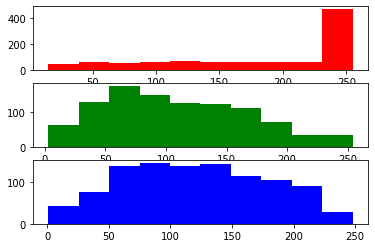

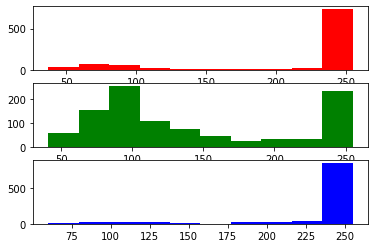

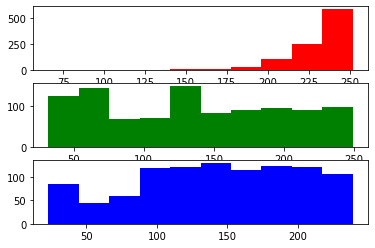

In [7]:
images, labels = load_CIFAR_batch(os.path.join('cifar-100-python', 'train'))
label_names = pickle.load(open(os.path.join('cifar-100-python', 'meta'), 'rb'), encoding='latin1')['coarse_label_names']

###########################################################################
# TODO: Randomly pick three input samples, display the images with labels # 
#.      and plot a histogram for each.                                    #
###########################################################################
for i in range(3):
  print(label_names[labels[i]])
  plt.imshow(images[i].astype('uint8'))
  plt.show()
  #print(label_names_fine[labels[i]])
for j in range(3):
  image=images[:32][:32][j]
  imagePlot=np.reshape(image,3072)
  fig = plt.figure()
  ax_1 = fig.add_subplot(311)
  #print('Red channel Histogram')
  ax_1.hist(imagePlot[:1024],color='Red')
  ax_2 = fig.add_subplot(312)
  #print('Green channel Histogram')
  ax_2.hist(imagePlot[1024:2048], color='Green')
  ax_3 = fig.add_subplot(313)
  #print('Blue Channel Histogram')
  ax_3.hist(imagePlot[2048:3072],color='Blue',label='Fruits')
  #plt.hist(r[:1024][:j])
#hisR= np.histogram(image[1])
#plt.hist(hisR,bins='auto')
###########################################################################
#             END OF YOUR CODE                                            #
###########################################################################

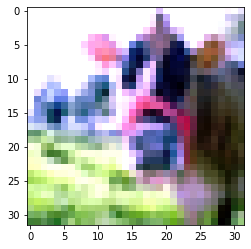

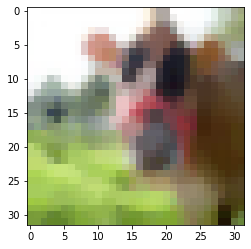

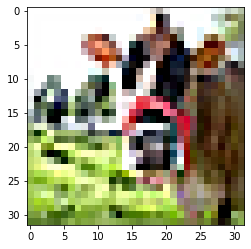

In [ ]:
#Q2 Display Preprocessed/Augmented Images
def load_CIFAR_batch_pp(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['coarse_labels']
    X = X.reshape(len(X), 3, 32, 32).transpose(0,2,3,1).astype("uint8") #change to uint8 while plotting image
    Y = np.array(Y)
    return X, Y
images1, labels1 = load_CIFAR_batch_pp(os.path.join('cifar-100-python', 'train'))
images1.shape
imageEqu=tfa.image.equalize(images1,256,None)
plt.imshow(imageEqu[0])
plt.show()
imageEqu2=tfa.image.median_filter2d(images1,(3, 3),'REFLECT',0,)
plt.imshow(imageEqu2[0])
plt.show()
imageEqu3=tfa.image.sharpness(images1,5,) 
plt.imshow(imageEqu3[0])
plt.show()
#plt.imshow(images[0]/255)
#image_gray=tf.image.rgb_to_grayscale(images[0])
#plt.imshow(image_gray)
#image_gray.shape

In [19]:
from tensorflow.keras.layers.experimental import preprocessing
def get_CIFAR100_data(num_training=49000, num_validation=1000, num_test=10000):
  """
  Load the CIFAR-100 dataset from disk and perform preprocessing to prepare
  it for training  
  """
  # Load the raw CIFAR-100 data
  cifar100_dir = 'cifar-100-python'
  X_train, y_train, X_test, y_test = load_CIFAR100(cifar100_dir)

  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  layer = preprocessing.Normalization()
  X_train=layer(X_train)
  X_val=layer(X_val)
  X_test=layer(X_test)
  X_train= X_train/255
  X_val=X_val/255
  X_test=X_test/255   #Many things to disable here
  ###########################################################################
  # TODO: Implement the data pre-processing                                 #
  ###########################################################################
  #X_train=tfa.image.sharpness(X_train,5)  ----- ENABLE THESE IMAGE PREPROCESSING/ AUGMENTATION- SHARPNESS
  #X_val= tfa.image.sharpness(X_test, 5)   ----- ENABLE THESE IMAGE PREPROCESSING/ AUGMENTATION- SHARPNESS
  #X_test=tfa.image.sharpness(X_test,5)    ------ ENABLE THESE IMAGE PREPROCESSING/ AUGMENTATION- SHARPNESS
  #X_train=tfa.image.equalize(X_train,256,None) ----ENABLE THESE IMAGE PREPROCESSING/ AUGMENTATION- EQUALIZATION
  #x_train=tf.image.rgb_to_grayscale(X_train) ------ ENABLE THESE IMAGE PREPROCESSING/ AUGMENTATION- EQUALZATION
  #X_train=tf.image.central_crop(X_train, 0.5)------ ENABLE THESE IMAGE PREPROCESSING/ AUGMENTATION- EQUALIZATION
  ###########################################################################
  #             END OF YOUR CODE                                            #
  ###########################################################################
  
  return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train[1:1000].shape

TensorShape([999, 32, 32, 3])

In [20]:
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR100_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,) int64
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [21]:
class Dataset(object):
  def __init__(self, X, y, batch_size, shuffle=False):
    """
    Construct a Dataset object to iterate over data X and labels y
    
    Inputs:
    - X: Numpy array of data, of any shape
    - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
    - batch_size: Integer giving number of elements per minibatch
    - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
    """
    assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
    self.X, self.y = X, y
    self.batch_size, self.shuffle = batch_size, shuffle

  def __iter__(self):
    N, B = self.X.shape[0], self.batch_size
    idxs = np.arange(N)
    if self.shuffle:
      np.random.shuffle(idxs)
    return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True) #just for experimenting
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)      #just for experimenting
test_dset = Dataset(X_test, y_test, batch_size=64)

In [11]:
# We can iterate through a dataset like this:
for t, (x, y) in enumerate(train_dset):
    print(t, x.shape, y.shape)
    if t > 5: break

0 (64, 32, 32, 3) (64,)
1 (64, 32, 32, 3) (64,)
2 (64, 32, 32, 3) (64,)
3 (64, 32, 32, 3) (64,)
4 (64, 32, 32, 3) (64,)
5 (64, 32, 32, 3) (64,)
6 (64, 32, 32, 3) (64,)


# Model

There are several ways to define the model. We use the low-level APIs in the example model below for flexibility. Check https://www.tensorflow.org/tutorials/images/classification for Sequential/Functional APIs.

In [12]:
#Q3 Lenet 5/CNN implementation
import tensorflow as tf

class ThreeLayerConvNet(tf.keras.Model):
  def __init__(self, channel_1, channel_2, num_classes, variance=2.0, reg1=None, reg2=None):
    super(ThreeLayerConvNet, self).__init__()
    print('Variance=')
    print(variance)
    print('Regularizer')
    print(reg1)
    initializer = tf.initializers.VarianceScaling(scale=variance)
    self.conv1 = tf.keras.layers.Conv2D(channel_1, [5,5], [1,1], padding='valid',
                                     kernel_initializer=initializer,
                                     activation=tf.nn.relu)
    if reg1 is not None:
      self.conv1 = tf.keras.layers.Conv2D(channel_1, [5,5], [1,1], padding='valid',
                                      kernel_initializer=initializer,
                                      kernel_regularizer=tf.keras.regularizers.l2(reg1),
                                      activation=tf.nn.relu)
    self.conv2 = tf.keras.layers.Conv2D(channel_2, [3,3], [1,1], padding='valid',
                                     kernel_initializer=initializer,
                                     activation=tf.nn.relu)
    if reg2 is not None:
      self.conv2 = tf.keras.layers.Conv2D(channel_2, [3,3], [1,1], padding='valid',
                                      kernel_initializer=initializer,
                                      kernel_regularizer=tf.keras.regularizers.l2(reg2),
                                      activation=tf.nn.relu)
    self.fc = tf.keras.layers.Dense(num_classes, kernel_initializer=initializer)
    self.flatten = tf.keras.layers.Flatten()   
    self.softmax = tf.keras.layers.Softmax()   
    
  def call(self, x, training=False):
    scores = None

    padding = tf.constant([[0,0],[2,2],[2,2],[0,0]])
    x = tf.pad(x, padding, 'CONSTANT')
    x = self.conv1(x)
    padding = tf.constant([[0,0],[1,1],[1,1],[0,0]])
    x = tf.pad(x, padding, 'CONSTANT')
    x = self.conv2(x)
    x = self.flatten(x)
    x = self.fc(x)
    scores = self.softmax(x)
       
    return scores

In [14]:
Var_lst=[1.0,2.0,3.0]
def model_init_fn(variance=2.0, reg1=None, reg2=None):
  ###########################################################################
  # TODO: Implement your model                                              #
  ###########################################################################
  model = None
  #model = ThreeLayerConvNet(channel_1,channel_2,num_classes,reg1=0.01, reg2=0.01)
  model = ThreeLayerConvNet(channel_1,channel_2,num_classes)
  ###########################################################################
  #             END OF YOUR CODE                                            #
  ###########################################################################
  return model

# Optimizer

In [15]:
def optimizer_init_fn(adam=False, learning_rate=0.01):
  ###########################################################################
  # TODO: Implement your optimizer                                          #
  ###########################################################################
  #opt=tf.keras.optimizers.SGD(learning_rate=0.1,nesterov=True,momentum=0.2) #Maxes out @23 at end of first epoch
  #opt=tf.keras.optimizers.SGD(learning_rate=0.01,nesterov=True,momentum=0.9)  #Goes in reverse direction
  opt=tf.keras.optimizers.SGD(learning_rate=0.1)
  #opt = tf.keras.optimizers.Adam(learning_rate=0.1)
  #print(learning_rate)
  ###########################################################################
  #             END OF YOUR CODE                                            #
  ###########################################################################
  return opt

# Loss

In [16]:
def loss_init_fn():
  ###########################################################################
  # TODO: Implement your loss                                               #
  ###########################################################################
  #loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  ###########################################################################
  #             END OF YOUR CODE                                            #
  ###########################################################################
  return loss

# Train

In [17]:
def train(model, optimizer, loss_fn, num_epochs=1, save_every_num_epoch=2, save_dir='tmp/', save_model_name='trained', is_training=False):
  """
  Simple training loop for use with models defined using tf.keras. It trains
  a model for one epoch on the CIFAR-100 training set and periodically checks
  accuracy on the CIFAR-100 validation set.
  
  Inputs:
  - num_epochs: The number of epochs to train for
  - save_every_num_epoch: The number of epochs to export the trained model
  - save_dir: Directory to export the trained model
  - save_model_name: Sub-directory to export the trained model (also the name to reload the model)
  
  Returns: Nothing, but prints progress during training
  """    
  train_accuracy_list, val_accuracy_list = [], []
  train_loss_list, val_loss_list = [], []
  with tf.device(device):
   
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

    val_loss = tf.keras.metrics.Mean(name='val_loss')
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
    
    t = 0
    for epoch in range(num_epochs):      
      # Reset the metrics - https://www.tensorflow.org/alpha/guide/migration_guide#new-style_metrics
      train_loss.reset_states()
      train_accuracy.reset_states()
      
      for x_np, y_np in train_dset:
        with tf.GradientTape() as tape:
          ###########################################################################
          # TODO: 1. Build forward pass with model                                  #    
          #       2. Compute the loss with loss_fn                                  #
          ###########################################################################
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
          logits = model(x_np, training=True)
          loss_value = loss(y_np, logits) 
          ###########################################################################
          #             END OF YOUR CODE                                            #
          ###########################################################################

          gradients = tape.gradient(loss_value, model.trainable_variables)
          optimizer.apply_gradients(zip(gradients, model.trainable_variables))
          
          # Update the metrics
          train_loss.update_state(loss_value)
          #train_accuracy.update_state(y_np, scores)
          train_accuracy.update_state(y_np,logits)
          if t % 100 == 0:
            val_loss.reset_states()
            val_accuracy.reset_states()
            for test_x, test_y in val_dset:
              ###########################################################################
              # TODO: 1. Run validation with model                                      #    
              #       2. Compute the loss with loss_fn                                  #
              ###########################################################################
              prediction = model(test_x, training=False)
              t_loss=loss(test_y, prediction)
              ###########################################################################
              #             END OF YOUR CODE                                            #
              ###########################################################################

              val_loss.update_state(t_loss)
              val_accuracy.update_state(test_y, prediction)
            
            template = 'Iteration {}, Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
            print (template.format(t, epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        val_loss.result(),
                        val_accuracy.result()*100))
            train_accuracy_list.append(train_accuracy.result())
            val_accuracy_list.append(val_accuracy.result())
            train_loss_list.append(train_loss.result())
            val_loss_list.append(val_loss.result())
          t += 1
      if epoch % save_every_num_epoch or epoch == num_epochs - 1:
        if not os.path.exists(save_dir):
          os.makedirs(save_dir)
        save_path = os.path.join(save_dir, save_model_name+'-'+str(epoch+1))
        tf.saved_model.save(model, save_path)

  plt.plot([i * 100 for i in range(len(train_accuracy_list))], train_accuracy_list, label='training accuracy')
  plt.plot([i * 100 for i in range(len(train_accuracy_list))], val_accuracy_list, label='validation accuracy')
  plt.title('training iterations vs accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('iterations')
  plt.legend(['training', 'validation'], loc='upper left')
  plt.show()

  plt.plot([i * 100 for i in range(len(train_accuracy_list))], train_loss_list, label='training loss')
  plt.plot([i * 100 for i in range(len(train_accuracy_list))], val_loss_list, label='validation loss')
  plt.title('training iterations vs loss')
  plt.ylabel('loss')
  plt.xlabel('iterations')
  plt.legend(['training', 'validation'], loc='upper left')
  plt.show()

  return train_accuracy_list[-1], val_accuracy_list[-1]

Variance=
2.0
Regularizer
None
Iteration 0, Epoch 1, Loss: 2.9953339099884033, Accuracy: 9.375, Val Loss: 2.9938321113586426, Val Accuracy: 6.5
Iteration 100, Epoch 1, Loss: 2.9648048877716064, Accuracy: 10.179455757141113, Val Loss: 2.9367735385894775, Val Accuracy: 12.0
Iteration 200, Epoch 1, Loss: 2.9358112812042236, Accuracy: 13.300683975219727, Val Loss: 2.89491605758667, Val Accuracy: 17.600000381469727
Iteration 300, Epoch 1, Loss: 2.921215534210205, Accuracy: 14.950166702270508, Val Loss: 2.9057600498199463, Val Accuracy: 16.5
Iteration 400, Epoch 1, Loss: 2.912731409072876, Accuracy: 15.874377250671387, Val Loss: 2.8737659454345703, Val Accuracy: 19.899999618530273
Iteration 500, Epoch 1, Loss: 2.902782440185547, Accuracy: 16.994136810302734, Val Loss: 2.875056505203247, Val Accuracy: 20.0
Iteration 600, Epoch 1, Loss: 2.8967511653900146, Accuracy: 17.6242733001709, Val Loss: 2.878093957901001, Val Accuracy: 19.400001525878906
Iteration 700, Epoch 1, Loss: 2.8905274868011475,

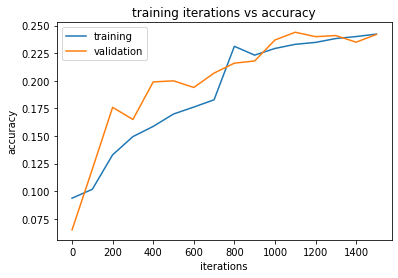

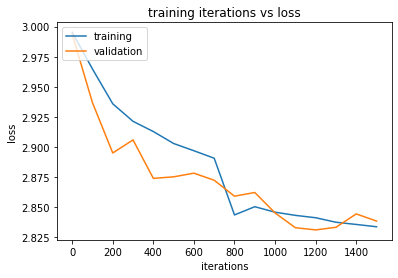

(<tf.Tensor: shape=(), dtype=float32, numpy=0.24232568>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.242>)

In [ ]:
#Q4 Training Accuracy and Validation Accuracy Comparison
channel_1, channel_2, num_classes = 32, 32, 20
model = model_init_fn()
optimizer = optimizer_init_fn()
loss = loss_init_fn()
train(model, optimizer, loss, num_epochs=2)

Iteration 0, Epoch 1, Test Loss: 4.900151252746582, Test Accuracy: 5.0
Iteration 100, Epoch 101, Test Loss: 4.900151252746582, Test Accuracy: 5.0
INFO:tensorflow:Assets written to: tmp/trained-102/assets


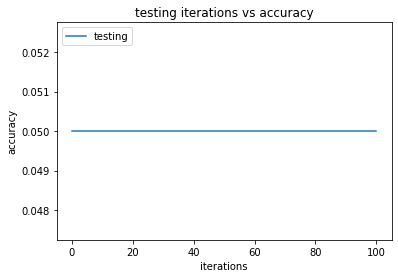

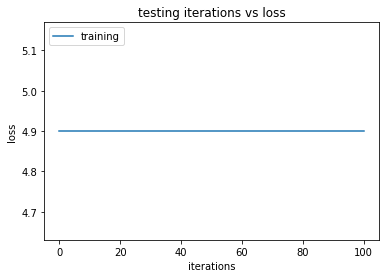

0 (64, 32, 32, 3) (64,)


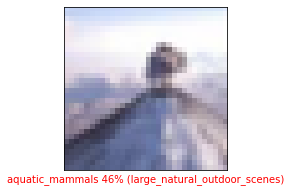

1 (64, 32, 32, 3) (64,)


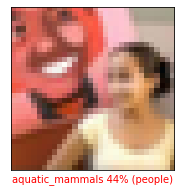

2 (64, 32, 32, 3) (64,)


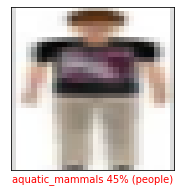

3 (64, 32, 32, 3) (64,)


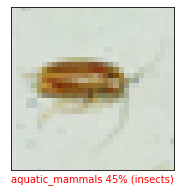

4 (64, 32, 32, 3) (64,)


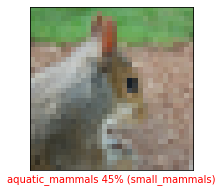

5 (64, 32, 32, 3) (64,)


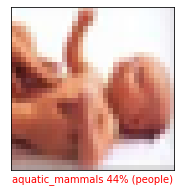

6 (64, 32, 32, 3) (64,)


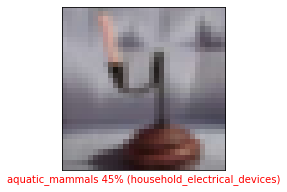

7 (64, 32, 32, 3) (64,)


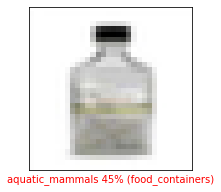

8 (64, 32, 32, 3) (64,)


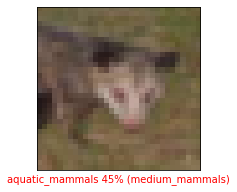

9 (64, 32, 32, 3) (64,)


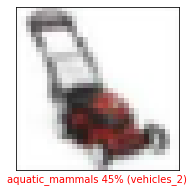

10 (64, 32, 32, 3) (64,)


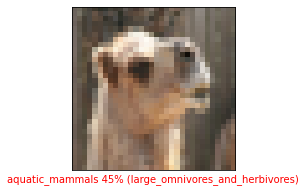

11 (64, 32, 32, 3) (64,)


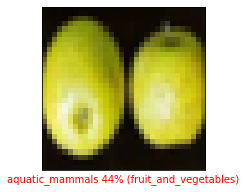

12 (64, 32, 32, 3) (64,)


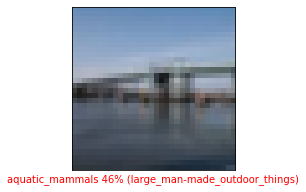

13 (64, 32, 32, 3) (64,)


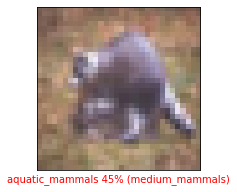

14 (64, 32, 32, 3) (64,)


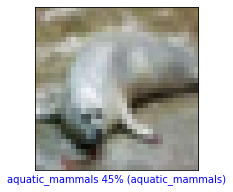

15 (64, 32, 32, 3) (64,)


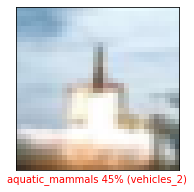

16 (64, 32, 32, 3) (64,)


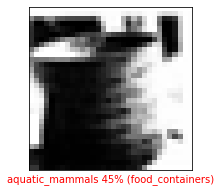

17 (64, 32, 32, 3) (64,)


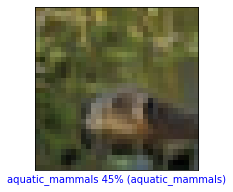

18 (64, 32, 32, 3) (64,)


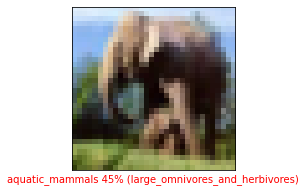

19 (64, 32, 32, 3) (64,)


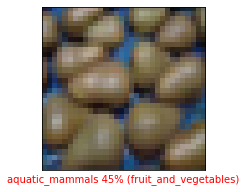

20 (64, 32, 32, 3) (64,)


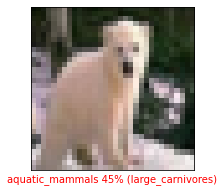

21 (64, 32, 32, 3) (64,)


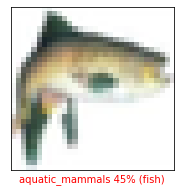

22 (64, 32, 32, 3) (64,)


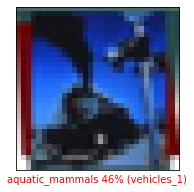

23 (64, 32, 32, 3) (64,)


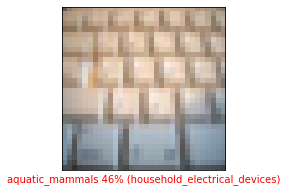

24 (64, 32, 32, 3) (64,)


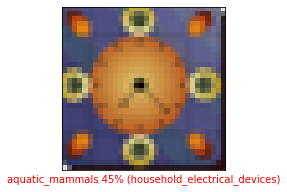

25 (64, 32, 32, 3) (64,)


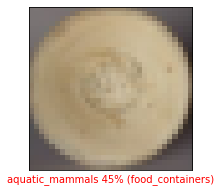

26 (64, 32, 32, 3) (64,)


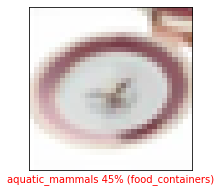

27 (64, 32, 32, 3) (64,)


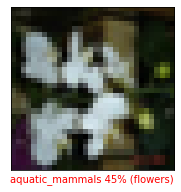

28 (64, 32, 32, 3) (64,)


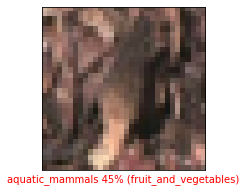

29 (64, 32, 32, 3) (64,)


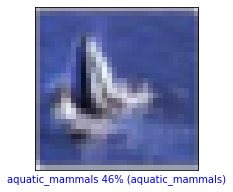

30 (64, 32, 32, 3) (64,)


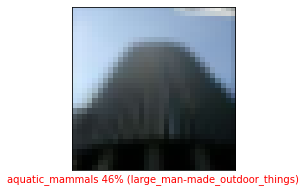

31 (64, 32, 32, 3) (64,)


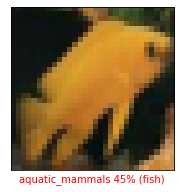

32 (64, 32, 32, 3) (64,)


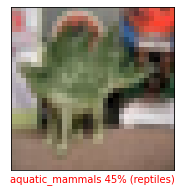

33 (64, 32, 32, 3) (64,)


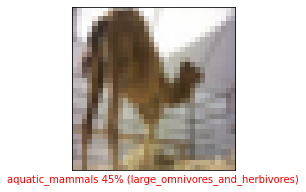

34 (64, 32, 32, 3) (64,)


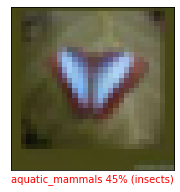

35 (64, 32, 32, 3) (64,)


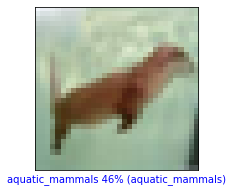

36 (64, 32, 32, 3) (64,)


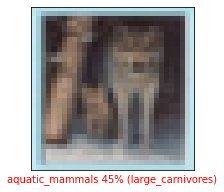

37 (64, 32, 32, 3) (64,)


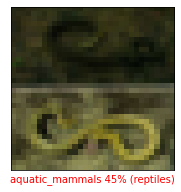

38 (64, 32, 32, 3) (64,)


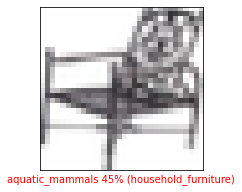

39 (64, 32, 32, 3) (64,)


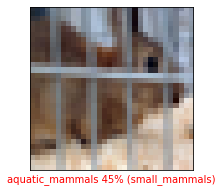

40 (64, 32, 32, 3) (64,)


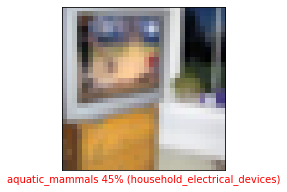

41 (64, 32, 32, 3) (64,)


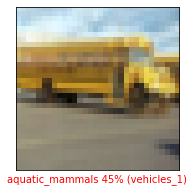

42 (64, 32, 32, 3) (64,)


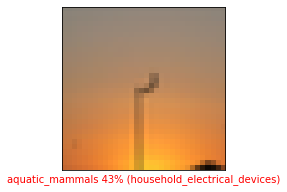

43 (64, 32, 32, 3) (64,)


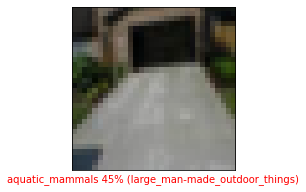

44 (64, 32, 32, 3) (64,)


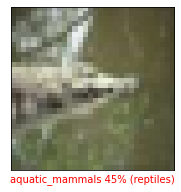

45 (64, 32, 32, 3) (64,)


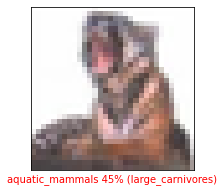

46 (64, 32, 32, 3) (64,)


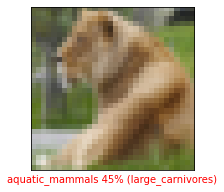

47 (64, 32, 32, 3) (64,)


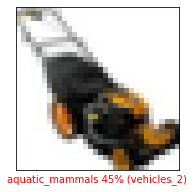

48 (64, 32, 32, 3) (64,)


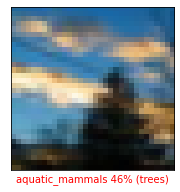

49 (64, 32, 32, 3) (64,)


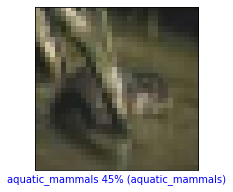

50 (64, 32, 32, 3) (64,)


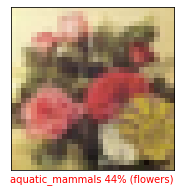

51 (64, 32, 32, 3) (64,)


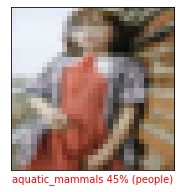

52 (64, 32, 32, 3) (64,)


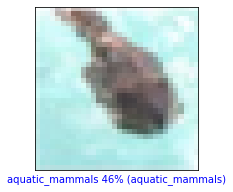

53 (64, 32, 32, 3) (64,)


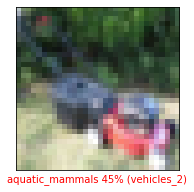

54 (64, 32, 32, 3) (64,)


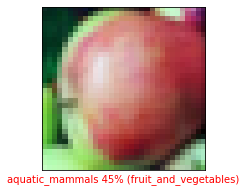

55 (64, 32, 32, 3) (64,)


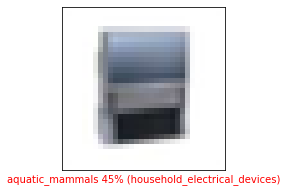

56 (64, 32, 32, 3) (64,)


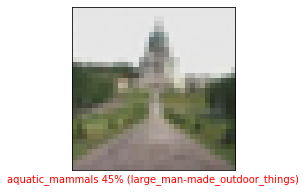

57 (64, 32, 32, 3) (64,)


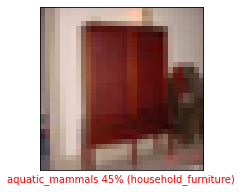

58 (64, 32, 32, 3) (64,)


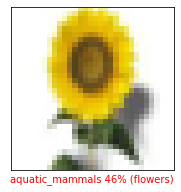

59 (64, 32, 32, 3) (64,)


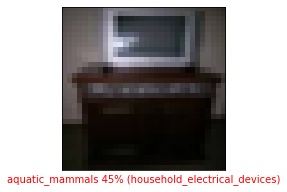

60 (64, 32, 32, 3) (64,)


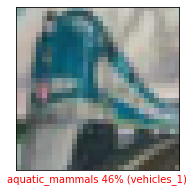

61 (64, 32, 32, 3) (64,)


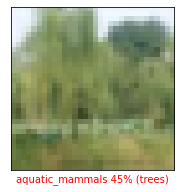

62 (64, 32, 32, 3) (64,)


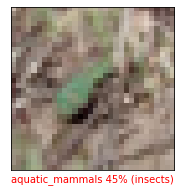

63 (64, 32, 32, 3) (64,)


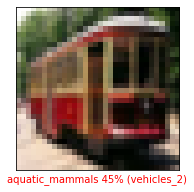

In [ ]:
#Q5 Printing testing accuracy
def test(model, optimizer, loss_fn, num_epochs=1, save_every_num_epoch=2, save_dir='tmp/', save_model_name='trained', is_training=False):
  """
  Simple training loop for use with models defined using tf.keras. It trains
  a model for one epoch on the CIFAR-100 training set and periodically checks
  accuracy on the CIFAR-100 validation set.
  
  Inputs:
  - num_epochs: The number of epochs to train for
  - save_every_num_epoch: The number of epochs to export the trained model
  - save_dir: Directory to export the trained model
  - save_model_name: Sub-directory to export the trained model (also the name to reload the model)
  
  Returns: Nothing, but prints progress during training
  """    
  test_accuracy_list= []
  test_loss_list= []
  with tf.device(device):
   

    test_loss = tf.keras.metrics.Mean(name='val_loss')
    test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
    
    t = 0
    for epoch in range(102): #Change it to 702 later      
      # Reset the metrics - https://www.tensorflow.org/alpha/guide/migration_guide#new-style_metrics
      test_loss.reset_states()
      test_accuracy.reset_states()
      
  
      if t % 100 == 0:
        test_loss.reset_states()
        test_accuracy.reset_states()
        for test_x, test_y in test_dset:
              ###########################################################################
              # TODO: 1. Run validation with model                                      #    
              #       2. Compute the loss with loss_fn                                  #
              ###########################################################################
              prediction = model(test_x/255, training=False)
              t_loss=loss(test_y, prediction)
              #plot_image(0, prediction, y_test, X_test)
              
              ###########################################################################
              #             END OF YOUR CODE                                            #
              ###########################################################################

              test_loss.update_state(t_loss)
              test_accuracy.update_state(test_y, prediction)
            
        template = 'Iteration {}, Epoch {}, Test Loss: {}, Test Accuracy: {}'
        print (template.format(t, epoch+1,
                        test_loss.result(),
                        test_accuracy.result()*100))
            #train_accuracy_list.append(train_accuracy.result())
        test_accuracy_list.append(test_accuracy.result())
              #train_loss_list.append(train_loss.result())
        test_loss_list.append(test_loss.result())
      t += 1
    if epoch % save_every_num_epoch or epoch == num_epochs - 1:
      if not os.path.exists(save_dir):
          os.makedirs(save_dir)
      save_path = os.path.join(save_dir, save_model_name+'-'+str(epoch+1))
      tf.saved_model.save(model, save_path)

  #plt.plot([i * 100 for i in range(len(train_accuracy_list))], train_accuracy_list, label='training accuracy')
  plt.plot([i * 100 for i in range(len(test_accuracy_list))], test_accuracy_list, label='testing accuracy')
  plt.title('testing iterations vs accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('iterations')
  plt.legend(['testing'], loc='upper left')
  plt.show()

  #plt.plot([i * 100 for i in range(len(train_accuracy_list))], train_loss_list, label='training loss')
  plt.plot([i * 100 for i in range(len(test_accuracy_list))], test_loss_list, label='testing loss')
  plt.title('testing iterations vs loss')
  plt.ylabel('loss')
  plt.xlabel('iterations')
  plt.legend(['training'], loc='upper left')
  plt.show()

  return test_accuracy_list[-1]
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary,)

  predicted_label = np.argmax(predictions_array)
  count1=0
  count2=0
  if predicted_label == true_label and count1<=2:
    color = 'blue'
    plt.xlabel("{} {:2.0f}% ({})".format(label_names[predicted_label],
                                100*np.max(predictions_array),
                                label_names[true_label]),
                                color=color)
    count1=count1+1
  else:
    color = 'red'
    if count2<=2:
      plt.xlabel("{} {:2.0f}% ({})".format(label_names[predicted_label],
                                100*np.max(predictions_array),
                                label_names[true_label]),
                                color=color)
    count2=count2+1
test(model, optimizer, loss, num_epochs=1)
i = 0
for t, (x, y) in enumerate(test_dset):
    print(t, x.shape, y.shape)
    prediction = model(x/255, training=False)
    t_loss=loss(y, prediction)
    #test_loss.update_state(t_loss)
    #test_accuracy.update_state(y, prediction)
    plt.figure(figsize=(6,3))
    #plt.subplot(1,2,1)
    plot_image(i, prediction[i], y, x)
    i=i+1
    #plt.subplot(1,2,2)
#plot_value_array(i, predictions[i],  test_labels)
    plt.show()
    if i > 63: break

0 (64, 32, 32, 3) (64,)


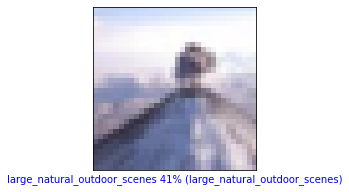

1 (64, 32, 32, 3) (64,)


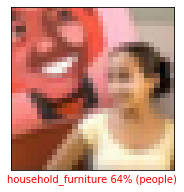

2 (64, 32, 32, 3) (64,)


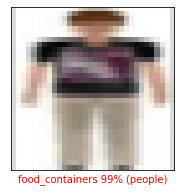

3 (64, 32, 32, 3) (64,)


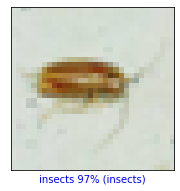

4 (64, 32, 32, 3) (64,)


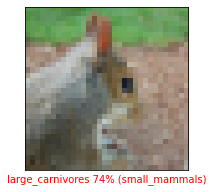

5 (64, 32, 32, 3) (64,)


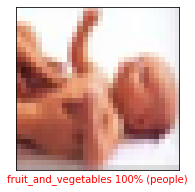

6 (64, 32, 32, 3) (64,)


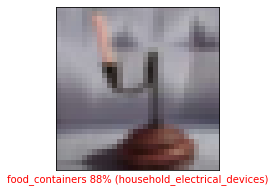

In [ ]:
#Selected Outputs Display

Iteration 0, Epoch 1, Loss: 2.9968948364257812, Accuracy: 6.25, Val Loss: 2.994560480117798, Val Accuracy: 6.300000190734863
Iteration 100, Epoch 1, Loss: 2.9722368717193604, Accuracy: 9.019183158874512, Val Loss: 2.9403085708618164, Val Accuracy: 13.300000190734863
Iteration 200, Epoch 1, Loss: 2.947376251220703, Accuracy: 11.94807243347168, Val Loss: 2.9253690242767334, Val Accuracy: 14.90000057220459
Iteration 300, Epoch 1, Loss: 2.933852195739746, Accuracy: 13.512250900268555, Val Loss: 2.9284253120422363, Val Accuracy: 13.600000381469727
Iteration 400, Epoch 1, Loss: 2.927394390106201, Accuracy: 14.269015312194824, Val Loss: 2.901076078414917, Val Accuracy: 16.799999237060547
Iteration 500, Epoch 1, Loss: 2.919487714767456, Accuracy: 15.091691970825195, Val Loss: 2.9081928730010986, Val Accuracy: 15.80000114440918
Iteration 600, Epoch 1, Loss: 2.912445068359375, Accuracy: 15.879782676696777, Val Loss: 2.8888862133026123, Val Accuracy: 17.899999618530273
Iteration 700, Epoch 1, Los

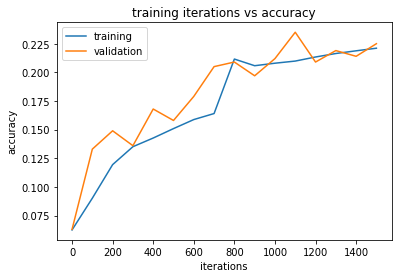

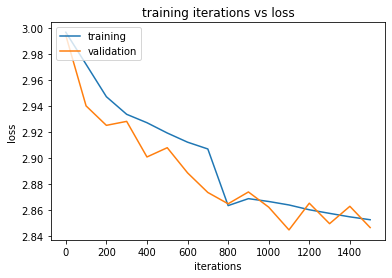

Iteration 0, Epoch 1, Loss: 2.998666524887085, Accuracy: 3.125, Val Loss: 3.003343343734741, Val Accuracy: 5.299999713897705
Iteration 100, Epoch 1, Loss: 2.9704692363739014, Accuracy: 9.761757850646973, Val Loss: 2.9268529415130615, Val Accuracy: 14.90000057220459
Iteration 200, Epoch 1, Loss: 2.9484152793884277, Accuracy: 12.119091987609863, Val Loss: 2.9047226905822754, Val Accuracy: 18.099998474121094
Iteration 300, Epoch 1, Loss: 2.9352641105651855, Accuracy: 13.584925651550293, Val Loss: 2.9238312244415283, Val Accuracy: 14.800000190734863
Iteration 400, Epoch 1, Loss: 2.929158926010132, Accuracy: 14.202774047851562, Val Loss: 2.896954298019409, Val Accuracy: 17.80000114440918
Iteration 500, Epoch 1, Loss: 2.9212751388549805, Accuracy: 15.016841888427734, Val Loss: 2.90384578704834, Val Accuracy: 17.100000381469727
Iteration 600, Epoch 1, Loss: 2.9147822856903076, Accuracy: 15.702995300292969, Val Loss: 2.885422945022583, Val Accuracy: 19.0
Iteration 700, Epoch 1, Loss: 2.9100723

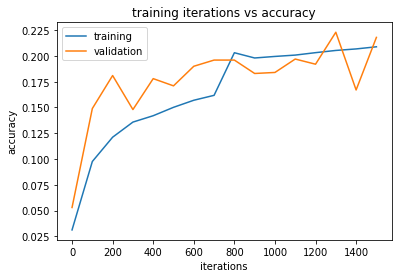

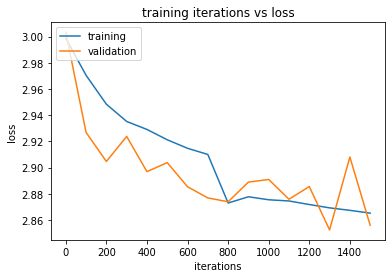

Iteration 0, Epoch 1, Loss: 2.9972786903381348, Accuracy: 7.8125, Val Loss: 3.0202999114990234, Val Accuracy: 5.600000381469727
Iteration 100, Epoch 1, Loss: 3.0272228717803955, Accuracy: 5.089727878570557, Val Loss: 3.021308183670044, Val Accuracy: 5.699999809265137
Iteration 200, Epoch 1, Loss: 3.0278899669647217, Accuracy: 5.021766185760498, Val Loss: 3.0214459896087646, Val Accuracy: 5.699999809265137
Iteration 300, Epoch 1, Loss: 3.0279996395111084, Accuracy: 5.00934362411499, Val Loss: 3.0281543731689453, Val Accuracy: 5.0
Iteration 400, Epoch 1, Loss: 3.0273683071136475, Accuracy: 5.073254108428955, Val Loss: 3.0281543731689453, Val Accuracy: 5.0
Iteration 500, Epoch 1, Loss: 3.027301073074341, Accuracy: 5.080463886260986, Val Loss: 3.0281543731689453, Val Accuracy: 5.0
Iteration 600, Epoch 1, Loss: 3.0271263122558594, Accuracy: 5.098273754119873, Val Loss: 3.0281543731689453, Val Accuracy: 5.0
Iteration 700, Epoch 1, Loss: 3.027090549468994, Accuracy: 5.102086544036865, Val Los

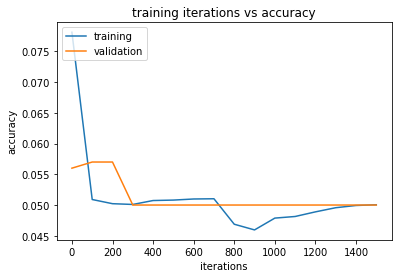

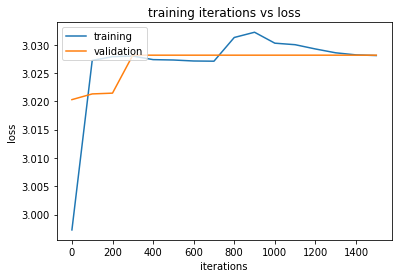

In [ ]:
#Q6 Sweeping variance Variable for training
variance_lst=[1.0, 2.0, 3.0]
learning_rate = 1e-3
channel_1, channel_2, num_classes = 32, 32, 20
Var_lst=[1.0,2.0,3.0]
for ind in range(3):
  def model_init_fn_var(variance=2.0, reg1=None, reg2=None):
  ###########################################################################
  # TODO: Implement your model                                              #
  ###########################################################################
    model = None
    model = ThreeLayerConvNet(channel_1,channel_2,num_classes,variance=Var_lst[ind])
  ###########################################################################
  #             END OF YOUR CODE                                            #
  ###########################################################################
    return model
  model = model_init_fn_var()
  optimizer = optimizer_init_fn()
  loss = loss_init_fn()
  train(model, optimizer, loss, num_epochs=2)

initializer variance
2.0
0.01
Iteration 0, Epoch 1, Loss: 3.0008018016815186, Accuracy: 3.125, Val Loss: 2.995382308959961, Val Accuracy: 5.099999904632568
Iteration 100, Epoch 1, Loss: 2.960545301437378, Accuracy: 10.597153663635254, Val Loss: 2.9173173904418945, Val Accuracy: 16.399999618530273
Iteration 200, Epoch 1, Loss: 2.9422919750213623, Accuracy: 12.772077560424805, Val Loss: 2.9264211654663086, Val Accuracy: 14.0
Iteration 300, Epoch 1, Loss: 2.9298903942108154, Accuracy: 14.135174751281738, Val Loss: 2.9041829109191895, Val Accuracy: 16.69999885559082
Iteration 400, Epoch 1, Loss: 2.920644521713257, Accuracy: 15.149625778198242, Val Loss: 2.8866848945617676, Val Accuracy: 18.799999237060547
Iteration 500, Epoch 1, Loss: 2.9095730781555176, Accuracy: 16.314247131347656, Val Loss: 2.8826310634613037, Val Accuracy: 18.899999618530273
Iteration 600, Epoch 1, Loss: 2.9024834632873535, Accuracy: 17.062707901000977, Val Loss: 2.874675750732422, Val Accuracy: 20.399999618530273
Iter

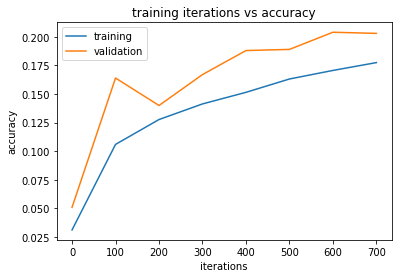

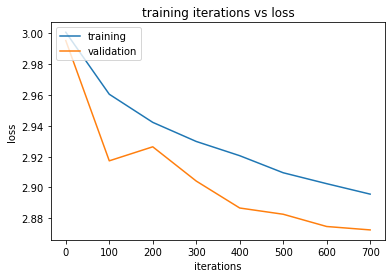

(<tf.Tensor: shape=(), dtype=float32, numpy=0.17746969>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.203>)

In [ ]:
#Q7; Adding Regularization to the model
reg_list=[0.01, 0.02]
channel_1, channel_2, num_classes = 32, 32, 20
for ind in range(2):
  def model_init_fn_reg(variance=2.0, reg1=None, reg2=None):
  ###########################################################################
  # TODO: Implement your model                                              #
  ###########################################################################
    model = None
    model = ThreeLayerConvNet(channel_1,channel_2,num_classes, reg1=reg_list[ind])
  ###########################################################################
  #             END OF YOUR CODE                                            #
  ###########################################################################
    return model
  model = model_init_fn_reg()
  optimizer = optimizer_init_fn()
  loss = loss_init_fn()
  train(model, optimizer, loss, num_epochs=2)
channel_1, channel_2, num_classes = 32, 32, 20
model = model_init_fn()
optimizer = optimizer_init_fn()
loss = loss_init_fn()
train(model, optimizer, loss, num_epochs=1)

initializer variance
2.0
Iteration 0, Epoch 1, Loss: 2.998532772064209, Accuracy: 6.25, Val Loss: 3.0226857662200928, Val Accuracy: 5.5
Iteration 100, Epoch 1, Loss: 3.030491828918457, Accuracy: 4.749381065368652, Val Loss: 3.0226857662200928, Val Accuracy: 5.5
Iteration 200, Epoch 1, Loss: 3.0290915966033936, Accuracy: 4.897387981414795, Val Loss: 3.0226857662200928, Val Accuracy: 5.5
Iteration 300, Epoch 1, Loss: 3.027472734451294, Accuracy: 5.061254501342773, Val Loss: 3.0226857662200928, Val Accuracy: 5.5
Iteration 400, Epoch 1, Loss: 3.0291550159454346, Accuracy: 4.894014835357666, Val Loss: 3.0226857662200928, Val Accuracy: 5.5
Iteration 500, Epoch 1, Loss: 3.0285439491271973, Accuracy: 4.955713272094727, Val Loss: 3.0226857662200928, Val Accuracy: 5.5
Iteration 600, Epoch 1, Loss: 3.0290462970733643, Accuracy: 4.905886173248291, Val Loss: 3.0226857662200928, Val Accuracy: 5.5
Iteration 700, Epoch 1, Loss: 3.0286920070648193, Accuracy: 4.941601276397705, Val Loss: 3.0226857662200

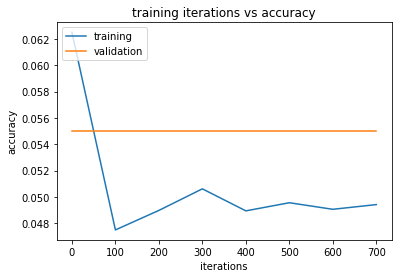

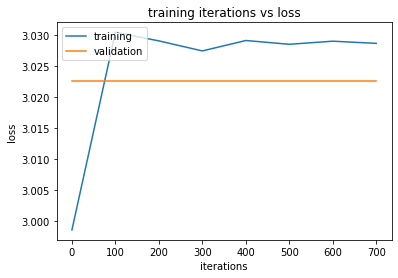

(<tf.Tensor: shape=(), dtype=float32, numpy=0.049416013>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.055>)

In [ ]:
#Q8 Train with Different Optimizers- Adam Optimizer in the current cell and SGD optimizer results in the next cell
#Run_step -  In Opt_init_func def change to Adam Optimizer
#learning_rate = 1e-3 #Train- 17.4, Val- oscillating reached 20.2- current
channel_1, channel_2, num_classes = 32, 16, 20
model = model_init_fn()
def optimizer_init_fn_adam(adam=False, learning_rate=0.01):
  opt = tf.keras.optimizers.Adam(learning_rate=0.1)
  return opt
optimizer = optimizer_init_fn_adam()
loss = loss_init_fn()
train(model, optimizer, loss, num_epochs=1)
channel_1, channel_2, num_classes = 32, 16, 20
model = model_init_fn()
def optimizer_init_fn_SGD(adam=False, learning_rate=0.01):  
  opt=tf.keras.optimizers.SGD(learning_rate=0.1)
  return opt
optimizer = optimizer_init_fn_SGD()
loss = loss_init_fn()
train(model, optimizer, loss, num_epochs=1)

Variance=
2.0
Regularizer
None
Iteration 0, Epoch 1, Loss: 2.995729446411133, Accuracy: 12.5, Val Loss: 2.996142625808716, Val Accuracy: 5.799999713897705
Iteration 100, Epoch 1, Loss: 2.984459400177002, Accuracy: 7.595916271209717, Val Loss: 2.9705512523651123, Val Accuracy: 9.5
Iteration 200, Epoch 1, Loss: 2.9600539207458496, Accuracy: 10.447761535644531, Val Loss: 2.919121265411377, Val Accuracy: 15.399999618530273
Iteration 300, Epoch 1, Loss: 2.944082498550415, Accuracy: 12.333887100219727, Val Loss: 2.9203081130981445, Val Accuracy: 15.09999942779541
Iteration 400, Epoch 1, Loss: 2.935661554336548, Accuracy: 13.353336334228516, Val Loss: 2.904132843017578, Val Accuracy: 16.599998474121094
Iteration 500, Epoch 1, Loss: 2.926572322845459, Accuracy: 14.343188285827637, Val Loss: 2.8934366703033447, Val Accuracy: 18.0
Iteration 600, Epoch 1, Loss: 2.91969895362854, Accuracy: 15.047836303710938, Val Loss: 2.890188217163086, Val Accuracy: 18.299999237060547
Iteration 700, Epoch 1, Los

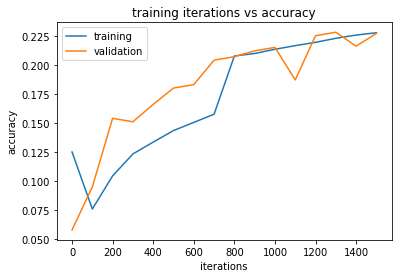

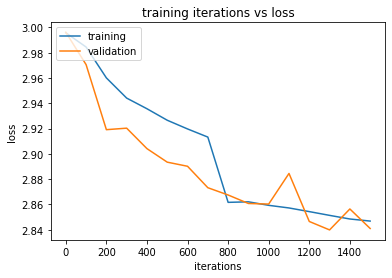

Variance=
2.0
Regularizer
None
Iteration 0, Epoch 1, Loss: 2.995347023010254, Accuracy: 4.6875, Val Loss: 2.9959816932678223, Val Accuracy: 5.299999713897705
Iteration 100, Epoch 1, Loss: 2.9937362670898438, Accuracy: 6.51299524307251, Val Loss: 2.9893929958343506, Val Accuracy: 8.399999618530273
Iteration 200, Epoch 1, Loss: 2.989893674850464, Accuracy: 7.128420352935791, Val Loss: 2.977325439453125, Val Accuracy: 8.800000190734863
Iteration 300, Epoch 1, Loss: 2.984757661819458, Accuracy: 7.802117824554443, Val Loss: 2.966644287109375, Val Accuracy: 10.100000381469727
Iteration 400, Epoch 1, Loss: 2.9788501262664795, Accuracy: 8.58011245727539, Val Loss: 2.952261209487915, Val Accuracy: 11.399999618530273
Iteration 500, Epoch 1, Loss: 2.973350763320923, Accuracy: 9.228418350219727, Val Loss: 2.943298101425171, Val Accuracy: 12.0
Iteration 600, Epoch 1, Loss: 2.9688525199890137, Accuracy: 9.866369247436523, Val Loss: 2.9320666790008545, Val Accuracy: 14.399999618530273
Iteration 700, 

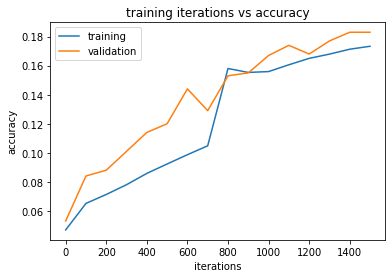

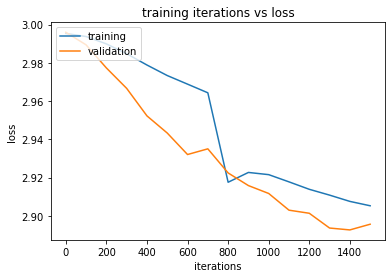

Variance=
2.0
Regularizer
None
Iteration 0, Epoch 1, Loss: 2.996659755706787, Accuracy: 6.25, Val Loss: 3.008121967315674, Val Accuracy: 6.599999904632568
Iteration 100, Epoch 1, Loss: 3.030446767807007, Accuracy: 4.749381065368652, Val Loss: 3.0226857662200928, Val Accuracy: 5.5
Iteration 200, Epoch 1, Loss: 3.029068946838379, Accuracy: 4.897387981414795, Val Loss: 3.0226857662200928, Val Accuracy: 5.5
Iteration 300, Epoch 1, Loss: 3.0274574756622314, Accuracy: 5.061254501342773, Val Loss: 3.0226857662200928, Val Accuracy: 5.5
Iteration 400, Epoch 1, Loss: 3.029143810272217, Accuracy: 4.894014835357666, Val Loss: 3.0226857662200928, Val Accuracy: 5.5
Iteration 500, Epoch 1, Loss: 3.0285348892211914, Accuracy: 4.955713272094727, Val Loss: 3.0226857662200928, Val Accuracy: 5.5
Iteration 600, Epoch 1, Loss: 3.029038667678833, Accuracy: 4.905886173248291, Val Loss: 3.0226857662200928, Val Accuracy: 5.5
Iteration 700, Epoch 1, Loss: 3.0286855697631836, Accuracy: 4.941601276397705, Val Loss

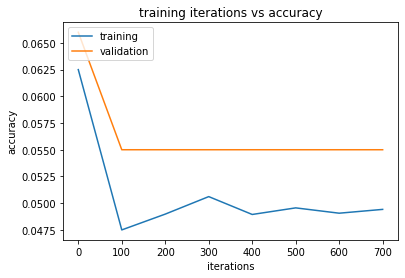

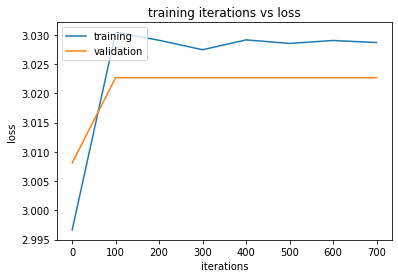

Variance=
2.0
Regularizer
None
Iteration 0, Epoch 1, Loss: 2.9848592281341553, Accuracy: 7.8125, Val Loss: 3.0230712890625, Val Accuracy: 5.400000095367432
Iteration 100, Epoch 1, Loss: 3.025247812271118, Accuracy: 5.275371074676514, Val Loss: 3.0230712890625, Val Accuracy: 5.400000095367432
Iteration 200, Epoch 1, Loss: 3.0260672569274902, Accuracy: 5.200559616088867, Val Loss: 3.0230705738067627, Val Accuracy: 5.400000095367432
Iteration 300, Epoch 1, Loss: 3.026801586151123, Accuracy: 5.128737449645996, Val Loss: 3.0230658054351807, Val Accuracy: 5.400000095367432
Iteration 400, Epoch 1, Loss: 3.0267763137817383, Accuracy: 5.131701946258545, Val Loss: 3.023045063018799, Val Accuracy: 5.400000095367432
Iteration 500, Epoch 1, Loss: 3.0269224643707275, Accuracy: 5.114770412445068, Val Loss: 3.0212888717651367, Val Accuracy: 5.600000381469727
Iteration 600, Epoch 1, Loss: 3.0270423889160156, Accuracy: 5.10347318649292, Val Loss: 3.022404670715332, Val Accuracy: 5.5
Iteration 700, Epoch

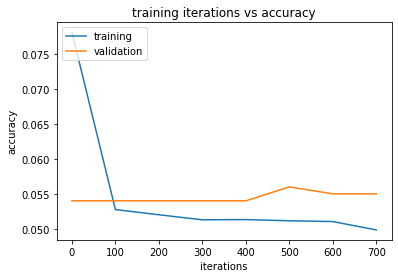

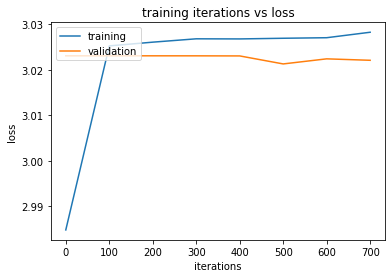

Variance=
2.0
Regularizer
None
Iteration 0, Epoch 1, Loss: 3.0007786750793457, Accuracy: 9.375, Val Loss: 2.9974606037139893, Val Accuracy: 5.0
Iteration 100, Epoch 1, Loss: 2.9957079887390137, Accuracy: 6.420173645019531, Val Loss: 2.9953255653381348, Val Accuracy: 5.200000286102295
Iteration 200, Epoch 1, Loss: 2.9953105449676514, Accuracy: 5.946828365325928, Val Loss: 2.993903636932373, Val Accuracy: 5.200000286102295
Iteration 300, Epoch 1, Loss: 2.994941473007202, Accuracy: 5.876245498657227, Val Loss: 2.9917211532592773, Val Accuracy: 5.299999713897705
Iteration 400, Epoch 1, Loss: 2.9946298599243164, Accuracy: 5.696695804595947, Val Loss: 2.989467144012451, Val Accuracy: 7.0
Iteration 500, Epoch 1, Loss: 2.993992328643799, Accuracy: 5.754117012023926, Val Loss: 2.988123893737793, Val Accuracy: 6.899999618530273
Iteration 600, Epoch 1, Loss: 2.993288516998291, Accuracy: 5.797628879547119, Val Loss: 2.986536979675293, Val Accuracy: 6.800000190734863
Iteration 700, Epoch 1, Loss: 2

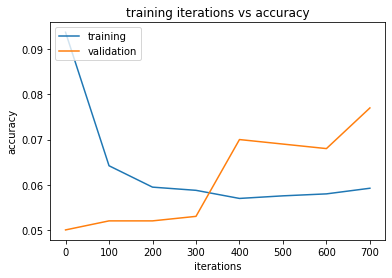

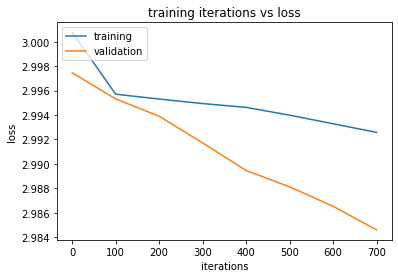

In [ ]:
#Q9 Train with Different Learning Rates
Learning_lst=[0.1,0.01]
channel_1, channel_2, num_classes = 32, 16, 20

for li in range(2):
  def optimizer_init_fn_learn(adam=False, learning_rate=0.01):
    opt=tf.keras.optimizers.SGD(learning_rate=Learning_lst[li])
    return opt
  model = model_init_fn()
  optimizer = optimizer_init_fn_learn()
  loss = loss_init_fn()
  train(model, optimizer, loss, num_epochs=2)
Learning_lst2=[10,1,0.001]
for li in range(3):
 def optimizer_init_fn_learn(adam=False, learning_rate=0.01):
    opt=tf.keras.optimizers.SGD(learning_rate=Learning_lst2[li])
    return opt
 model = model_init_fn()
 optimizer = optimizer_init_fn_learn()
 loss = loss_init_fn()
 train(model, optimizer, loss, num_epochs=1)
#Data Augmentation- Has increased the accuracy of the model by ~1 percent in Epoch compared to the iteration without Data Augmentation

In [ ]:
#Q9 Choice of Different Learning Configs
#Learning Rate of 0.1 seems to have performed the best- more details in the Report attached


Iteration 0, Epoch 1, Loss: 2.9989662170410156, Accuracy: 6.25, Val Loss: 2.9938297271728516, Val Accuracy: 5.600000381469727
Iteration 100, Epoch 1, Loss: 2.9611589908599854, Accuracy: 10.41150951385498, Val Loss: 2.911329984664917, Val Accuracy: 15.899999618530273
Iteration 200, Epoch 1, Loss: 2.934418201446533, Accuracy: 13.347326278686523, Val Loss: 2.8836445808410645, Val Accuracy: 20.200000762939453
Iteration 300, Epoch 1, Loss: 2.9169294834136963, Accuracy: 15.401784896850586, Val Loss: 2.8977205753326416, Val Accuracy: 17.5
Iteration 400, Epoch 1, Loss: 2.9070498943328857, Accuracy: 16.478336334228516, Val Loss: 2.858119010925293, Val Accuracy: 21.899999618530273
Iteration 500, Epoch 1, Loss: 2.8975939750671387, Accuracy: 17.483783721923828, Val Loss: 2.8613009452819824, Val Accuracy: 20.80000114440918
Iteration 600, Epoch 1, Loss: 2.892172336578369, Accuracy: 18.061044692993164, Val Loss: 2.8778536319732666, Val Accuracy: 19.200000762939453
Iteration 700, Epoch 1, Loss: 2.8868

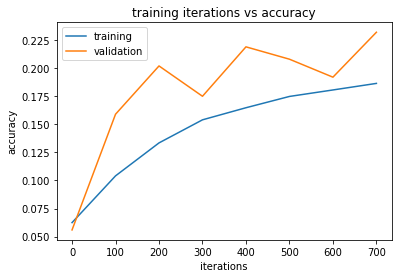

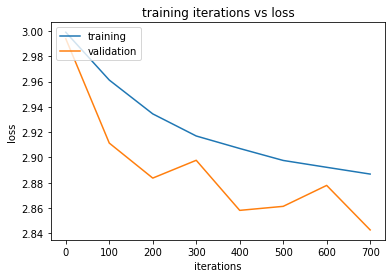

(<tf.Tensor: shape=(), dtype=float32, numpy=0.18645239>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.232>)

In [ ]:
#Current SGD- Momentum 0.2- no preprocessing 1e-2 learning, Channels2= 32, V
#VERY HIGH ACCURACY, TRY TO RETAIN THE CURRENT MODEL
learning_rate = 1e-2   #Using plain Colab template ,
channel_1, channel_2, num_classes = 32, 32, 20
model = model_init_fn()
optimizer = optimizer_init_fn()
loss = loss_init_fn()
train(model, optimizer, loss, num_epochs=1)

initializer variance
2.0
Iteration 0, Epoch 1, Loss: 2.9909489154815674, Accuracy: 7.8125, Val Loss: 2.9970784187316895, Val Accuracy: 5.200000286102295
Iteration 100, Epoch 1, Loss: 3.0247113704681396, Accuracy: 5.043316841125488, Val Loss: 2.9907569885253906, Val Accuracy: 7.0
Iteration 200, Epoch 1, Loss: 2.9917213916778564, Accuracy: 7.929104804992676, Val Loss: 2.933349847793579, Val Accuracy: 13.09999942779541
Iteration 300, Epoch 1, Loss: 2.9683494567871094, Accuracy: 10.319766998291016, Val Loss: 2.920074939727783, Val Accuracy: 14.800000190734863
Iteration 400, Epoch 1, Loss: 2.9526729583740234, Accuracy: 11.876558303833008, Val Loss: 2.8946704864501953, Val Accuracy: 17.899999618530273
Iteration 500, Epoch 1, Loss: 2.939932346343994, Accuracy: 13.129989624023438, Val Loss: 2.8921689987182617, Val Accuracy: 17.80000114440918
Iteration 600, Epoch 1, Loss: 2.929136037826538, Accuracy: 14.244487762451172, Val Loss: 2.8757338523864746, Val Accuracy: 19.600000381469727
Iteration 70

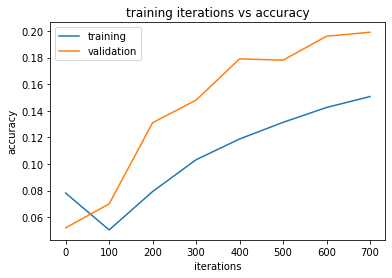

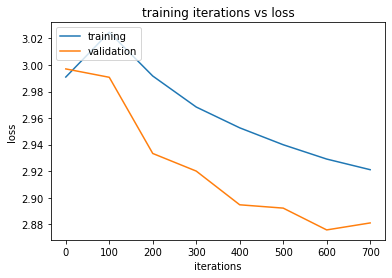

(<tf.Tensor: shape=(), dtype=float32, numpy=0.1506776>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.199>)

In [ ]:
#Q10 #Without any Preprocessing technique, Testing rate- 20.2
#Changing learning rate to 1e-2 without sharpness+SGD+Momem=0.2, nest=true
#Hyperparameter training
learning_rate = 1e-3 #Train- 17.4, Val- oscillating reached 20.2- current
channel_1, channel_2, num_classes = 32, 16, 20
model = model_init_fn()
optimizer = optimizer_init_fn()
loss = loss_init_fn()
train(model, optimizer, loss, num_epochs=1)

Iteration 0, Epoch 1, Test Loss: 2.8687267303466797, Test Accuracy: 20.440000534057617
Iteration 100, Epoch 101, Test Loss: 2.8687267303466797, Test Accuracy: 20.440000534057617
INFO:tensorflow:Assets written to: tmp/trained-102/assets


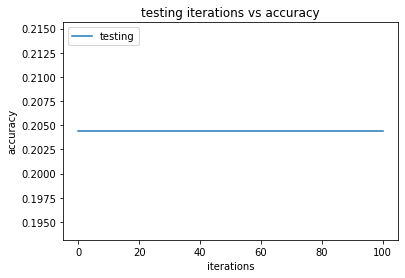

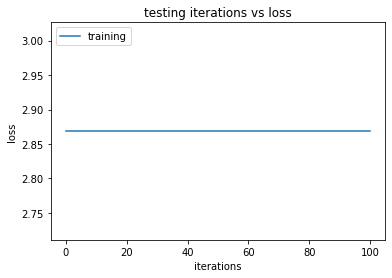

<tf.Tensor: shape=(), dtype=float32, numpy=0.2044>

In [ ]:
test(model, optimizer, loss, num_epochs=1)

Variance=
2.0
Regularizer
None
Iteration 0, Epoch 1, Loss: 3.001232624053955, Accuracy: 4.6875, Val Loss: 2.998148202896118, Val Accuracy: 5.600000381469727
Iteration 100, Epoch 1, Loss: 2.9743659496307373, Accuracy: 9.251237869262695, Val Loss: 2.929525136947632, Val Accuracy: 14.30000114440918
Iteration 200, Epoch 1, Loss: 2.954347610473633, Accuracy: 11.473880767822266, Val Loss: 2.9022724628448486, Val Accuracy: 17.299999237060547
Iteration 300, Epoch 1, Loss: 2.9392757415771484, Accuracy: 13.096968650817871, Val Loss: 2.910188913345337, Val Accuracy: 15.899999618530273
Iteration 400, Epoch 1, Loss: 2.9299910068511963, Accuracy: 14.046913146972656, Val Loss: 2.8881800174713135, Val Accuracy: 18.399999618530273
Iteration 500, Epoch 1, Loss: 2.922626495361328, Accuracy: 14.864021301269531, Val Loss: 2.885838031768799, Val Accuracy: 18.5
Iteration 600, Epoch 1, Loss: 2.9170114994049072, Accuracy: 15.417012214660645, Val Loss: 2.878035306930542, Val Accuracy: 19.799999237060547
Iterati

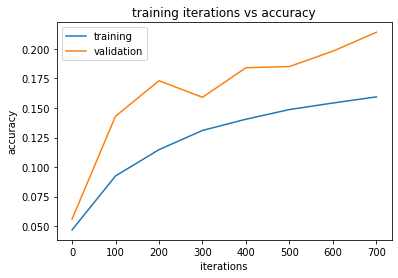

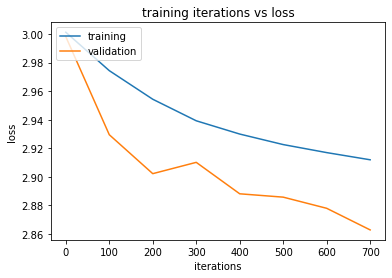

(<tf.Tensor: shape=(), dtype=float32, numpy=0.15934825>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.214>)

In [ ]:
#Q10 With Data Augmentation- Scaling and sharpening
#Running- In get_CIFAR100_data definition, include data augmentation, then pass it to data set and run training
# ENABLE- SHARPENING IN get_CIFAR100_data
learning_rate = 1e-3 #Train- 17.4, Val- oscillating reached 20.2- current
channel_1, channel_2, num_classes = 32, 16, 20
model = model_init_fn()
optimizer = optimizer_init_fn()
loss = loss_init_fn()
train(model, optimizer, loss, num_epochs=1)
#Data Augmentation- Has increased the accuracy of the model by ~1 percent in Epoch compared to the iteration without Data Augmentation

Iteration 0, Epoch 1, Test Loss: 2.865997314453125, Test Accuracy: 20.71000099182129
Iteration 100, Epoch 101, Test Loss: 2.865997314453125, Test Accuracy: 20.71000099182129
INFO:tensorflow:Assets written to: tmp/trained-102/assets


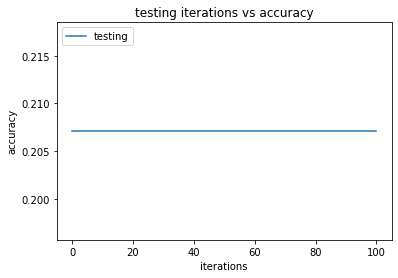

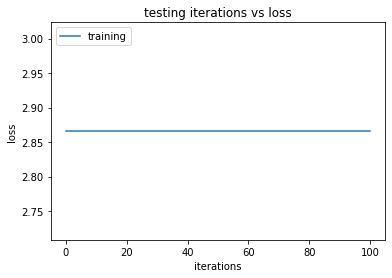

<tf.Tensor: shape=(), dtype=float32, numpy=0.2071>

In [ ]:
test(model, optimizer, loss, num_epochs=1)

initializer variance
2.0
Iteration 0, Epoch 1, Loss: 2.9986376762390137, Accuracy: 1.5625, Val Loss: 2.995997190475464, Val Accuracy: 5.099999904632568
Iteration 100, Epoch 1, Loss: 2.973888397216797, Accuracy: 8.84900951385498, Val Loss: 2.951124668121338, Val Accuracy: 10.699999809265137
Iteration 200, Epoch 1, Loss: 2.95375394821167, Accuracy: 11.108519554138184, Val Loss: 2.923727512359619, Val Accuracy: 15.299999237060547
Iteration 300, Epoch 1, Loss: 2.941214084625244, Accuracy: 12.64534854888916, Val Loss: 2.9447340965270996, Val Accuracy: 11.699999809265137
Iteration 400, Epoch 1, Loss: 2.9333529472351074, Accuracy: 13.544264793395996, Val Loss: 2.9021332263946533, Val Accuracy: 17.299999237060547
Iteration 500, Epoch 1, Loss: 2.9260053634643555, Accuracy: 14.371257781982422, Val Loss: 2.9068002700805664, Val Accuracy: 16.5
Iteration 600, Epoch 1, Loss: 2.9183192253112793, Accuracy: 15.227225303649902, Val Loss: 2.8792238235473633, Val Accuracy: 19.200000762939453
Iteration 700

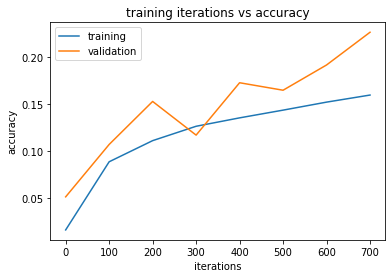

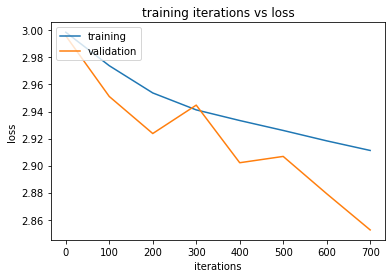

(<tf.Tensor: shape=(), dtype=float32, numpy=0.15983862>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.227>)

In [ ]:
#Q10 With Data Augmentation: Histogram Equalization
#ENABLE HISTOGRAM EQUALIZATION IN get_CIFAR100_data
learning_rate = 1e-3 #Train- 17.4, Val- oscillating reached 20.2- current
channel_1, channel_2, num_classes = 32, 16, 20
model = model_init_fn()
optimizer = optimizer_init_fn()
loss = loss_init_fn()
train(model, optimizer, loss, num_epochs=1)
#Data Augmentation- Has increased the accuracy of the model by ~1 percent in Epoch compared to the iteration without Data Augmentation

Iteration 0, Epoch 1, Test Loss: 2.854316234588623, Test Accuracy: 22.190000534057617
Iteration 100, Epoch 101, Test Loss: 2.854316234588623, Test Accuracy: 22.190000534057617
Iteration 200, Epoch 201, Test Loss: 2.854316234588623, Test Accuracy: 22.190000534057617
Iteration 300, Epoch 301, Test Loss: 2.854316234588623, Test Accuracy: 22.190000534057617
Iteration 400, Epoch 401, Test Loss: 2.854316234588623, Test Accuracy: 22.190000534057617
Iteration 500, Epoch 501, Test Loss: 2.854316234588623, Test Accuracy: 22.190000534057617
Iteration 600, Epoch 601, Test Loss: 2.854316234588623, Test Accuracy: 22.190000534057617
Iteration 700, Epoch 701, Test Loss: 2.854316234588623, Test Accuracy: 22.190000534057617
INFO:tensorflow:Assets written to: tmp/trained-702/assets


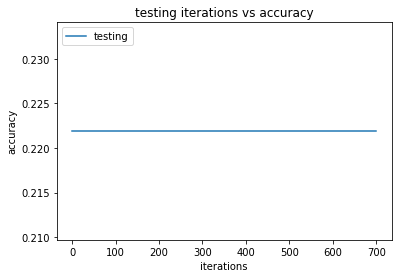

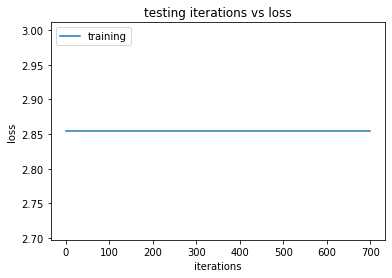

<tf.Tensor: shape=(), dtype=float32, numpy=0.2219>

In [ ]:
test(model, optimizer, loss, num_epochs=1)

Variance=
2.0
Regularizer
None
Iteration 0, Epoch 1, Loss: 2.994342565536499, Accuracy: 3.125, Val Loss: 2.999382495880127, Val Accuracy: 5.5
Iteration 100, Epoch 1, Loss: 2.980398416519165, Accuracy: 8.323019981384277, Val Loss: 2.9548094272613525, Val Accuracy: 11.5
Iteration 200, Epoch 1, Loss: 2.958245038986206, Accuracy: 10.984142303466797, Val Loss: 2.9359638690948486, Val Accuracy: 13.40000057220459
Iteration 300, Epoch 1, Loss: 2.9477529525756836, Accuracy: 12.136628150939941, Val Loss: 2.91914701461792, Val Accuracy: 15.899999618530273
Iteration 400, Epoch 1, Loss: 2.9378411769866943, Accuracy: 13.380611419677734, Val Loss: 2.899998903274536, Val Accuracy: 17.899999618530273
Iteration 500, Epoch 1, Loss: 2.9274442195892334, Accuracy: 14.480413436889648, Val Loss: 2.8978071212768555, Val Accuracy: 16.799999237060547
Iteration 600, Epoch 1, Loss: 2.9189748764038086, Accuracy: 15.440411567687988, Val Loss: 2.8942995071411133, Val Accuracy: 17.600000381469727
Iteration 700, Epoch 

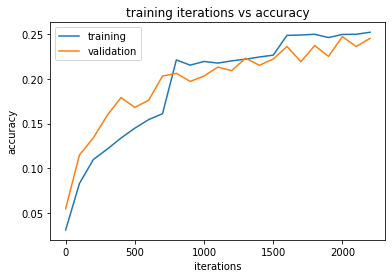

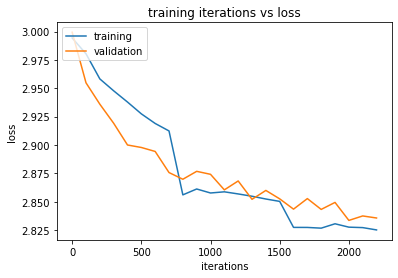

(<tf.Tensor: shape=(), dtype=float32, numpy=0.25189182>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.245>)

In [ ]:
#Q11 Best Test Accuracy of 25 after 3 peochs and 27 after 6 peochs
channel_1, channel_2, num_classes = 32, 32, 20
model = model_init_fn()
optimizer = optimizer_init_fn()
loss = loss_init_fn()
train(model, optimizer, loss, num_epochs=3)

Iteration 0, Epoch 1, Test Loss: 8.249961853027344, Test Accuracy: 24.799999237060547
Iteration 100, Epoch 101, Test Loss: 8.249961853027344, Test Accuracy: 24.799999237060547
INFO:tensorflow:Assets written to: tmp/trained-102/assets


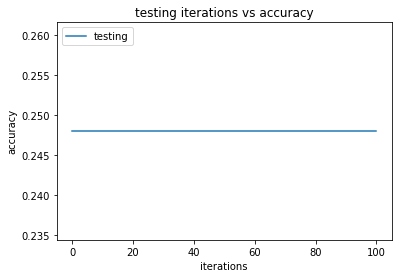

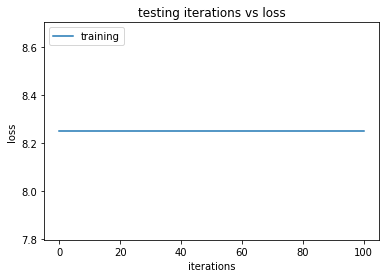

<tf.Tensor: shape=(), dtype=float32, numpy=0.248>

In [ ]:
test(model, optimizer, loss, num_epochs=1)

In [ ]:
#Same model when trained over > 6 epochs
#gave the following test result

Iteration 0, Epoch 1, Test Loss: 2.804525852203369, Test Accuracy: 27.190000534057617
Iteration 100, Epoch 101, Test Loss: 2.804525852203369, Test Accuracy: 27.190000534057617
Iteration 200, Epoch 201, Test Loss: 2.804525852203369, Test Accuracy: 27.190000534057617
Iteration 300, Epoch 301, Test Loss: 2.804525852203369, Test Accuracy: 27.190000534057617
Iteration 400, Epoch 401, Test Loss: 2.804525852203369, Test Accuracy: 27.190000534057617
Iteration 500, Epoch 501, Test Loss: 2.804525852203369, Test Accuracy: 27.190000534057617
Iteration 600, Epoch 601, Test Loss: 2.804525852203369, Test Accuracy: 27.190000534057617
Iteration 700, Epoch 701, Test Loss: 2.804525852203369, Test Accuracy: 27.190000534057617
INFO:tensorflow:Assets written to: tmp/trained-702/assets


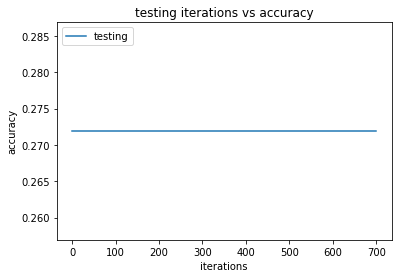

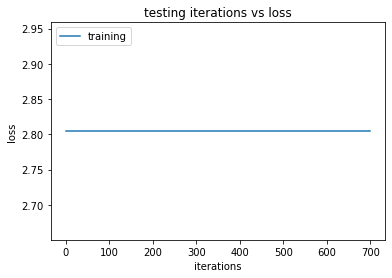

<tf.Tensor: shape=(), dtype=float32, numpy=0.2719>

In [ ]:
test(model, optimizer, loss, num_epochs=1)

In [22]:
channel_1, channel_2, num_classes = 32, 32, 20
model = model_init_fn()
optimizer = optimizer_init_fn()
loss = loss_init_fn()
train(model, optimizer, loss, num_epochs=1)

Variance=
2.0
Regularizer
None
Iteration 0, Epoch 1, Loss: 3.046288013458252, Accuracy: 3.125, Val Loss: 3.023076295852661, Val Accuracy: 5.400000095367432
Iteration 100, Epoch 1, Loss: 3.0258595943450928, Accuracy: 5.2289605140686035, Val Loss: 3.023076295852661, Val Accuracy: 5.400000095367432


KeyboardInterrupt: ignored

In [ ]:
#Q12 Answer = to Q12, added two max pool layers
import tensorflow as tf

class ThreeLayerConvNet(tf.keras.Model):
  def __init__(self, channel_1, channel_2, num_classes, variance=2.0, reg1=None, reg2=None):
    super(ThreeLayerConvNet, self).__init__()

    initializer = tf.initializers.VarianceScaling(scale=variance)
    print('initializer variance')
    print(variance)
    self.conv1 = tf.keras.layers.Conv2D(channel_1, [5,5], [1,1], padding='valid',
                                     kernel_initializer=initializer,
                                     activation=tf.nn.relu)
    self.conv1 = tf.keras.layers.Conv2D(channel_1, [5,5], [1,1], padding='valid',
                                     kernel_initializer=initializer,
                                     activation=tf.nn.relu)
    if reg1 is not None:
      self.conv1 = tf.keras.layers.Conv2D(channel_1, [5,5], [1,1], padding='valid',
                                      kernel_initializer=initializer,
                                      kernel_regularizer=tf.keras.regularizers.l2(reg1),
                                      activation=tf.nn.relu)
    self.Pooling1 =tf.keras.layers.AveragePooling2D(pool_size=(5, 5), strides=(1, 1), padding='valid')
    self.conv2 = tf.keras.layers.Conv2D(channel_2, [3,3], [1,1], padding='valid',
                                     kernel_initializer=initializer,
                                     activation=tf.nn.relu)
    self.conv2 = tf.keras.layers.Conv2D(channel_2, [3,3], [1,1], padding='valid',
                                     kernel_initializer=initializer,
                                     activation=tf.nn.relu)
    if reg2 is not None:
      self.conv2 = tf.keras.layers.Conv2D(channel_2, [3,3], [1,1], padding='valid',
                                      kernel_initializer=initializer,
                                      kernel_regularizer=tf.keras.regularizers.l2(reg2),
                                      activation=tf.nn.relu)
  
    self.Pooling2 = tf.keras.layers.AveragePooling2D(pool_size=(5, 5), strides=(1, 1), padding='valid')
    self.fc = tf.keras.layers.Dense(num_classes, kernel_initializer=initializer)
    self.flatten = tf.keras.layers.Flatten()   
    self.softmax = tf.keras.layers.Softmax()   
    
  def call(self, x, training=False):
    scores = None

    padding = tf.constant([[0,0],[2,2],[2,2],[0,0]])
    x = tf.pad(x, padding, 'CONSTANT')
    x = self.conv1(x)
    padding = tf.constant([[0,0],[1,1],[1,1],[0,0]])
    x = tf.pad(x, padding, 'CONSTANT')
    x = self.Pooling1(x)
    x = self.conv2(x)
    x = self.Pooling2(x)
    x = self.flatten(x)
    x = self.fc(x)
    scores = self.softmax(x)
       
    return scores

initializer variance
2.0
Iteration 0, Epoch 1, Loss: 2.997450828552246, Accuracy: 3.125, Val Loss: 2.995659351348877, Val Accuracy: 5.5
Iteration 100, Epoch 1, Loss: 2.982797145843506, Accuracy: 7.797029495239258, Val Loss: 2.959643602371216, Val Accuracy: 11.800000190734863
Iteration 200, Epoch 1, Loss: 2.9605557918548584, Accuracy: 10.572138786315918, Val Loss: 2.9356465339660645, Val Accuracy: 13.40000057220459
Iteration 300, Epoch 1, Loss: 2.9481077194213867, Accuracy: 11.986087799072266, Val Loss: 2.9361510276794434, Val Accuracy: 12.800000190734863
Iteration 400, Epoch 1, Loss: 2.9404938220977783, Accuracy: 12.897443771362305, Val Loss: 2.8959193229675293, Val Accuracy: 18.0
Iteration 500, Epoch 1, Loss: 2.931460380554199, Accuracy: 13.90968132019043, Val Loss: 2.896566152572632, Val Accuracy: 18.299999237060547
Iteration 600, Epoch 1, Loss: 2.9236795902252197, Accuracy: 14.769655227661133, Val Loss: 2.8852474689483643, Val Accuracy: 19.0
Iteration 700, Epoch 1, Loss: 2.916189908

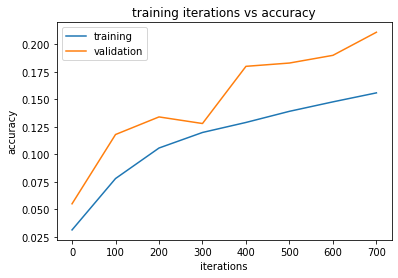

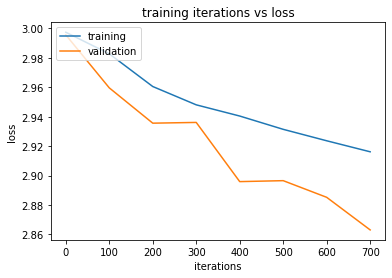

(<tf.Tensor: shape=(), dtype=float32, numpy=0.15587108>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.211>)

In [ ]:
#Q12 Answer = to Q12, added two max pool layers
#Example Training - Try with Loss- Logits, optimizer- Nest- F, input scaling related changes

learning_rate = 1e-3   #Using plain Colab template
channel_1, channel_2, num_classes = 32, 32, 20
model = model_init_fn()
optimizer = optimizer_init_fn()
loss = loss_init_fn()
train(model, optimizer, loss, num_epochs=1)

In [ ]:
#Show testing accuracy here
#Show model summary here of modified architecture
model.summary()

Model: "three_layer_conv_net_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          multiple                  2432      
_________________________________________________________________
average_pooling2d_14 (Averag multiple                  0         
_________________________________________________________________
conv2d_106 (Conv2D)          multiple                  9248      
_________________________________________________________________
average_pooling2d_15 (Averag multiple                  0         
_________________________________________________________________
dense_41 (Dense)             multiple                  368660    
_________________________________________________________________
flatten_41 (Flatten)         multiple                  0         
_________________________________________________________________
softmax_41 (Softmax)         multiple      

Iteration 0, Epoch 1, Test Loss: 6.483409404754639, Test Accuracy: 21.119998931884766
Iteration 100, Epoch 101, Test Loss: 6.483409404754639, Test Accuracy: 21.119998931884766
INFO:tensorflow:Assets written to: tmp/trained-102/assets


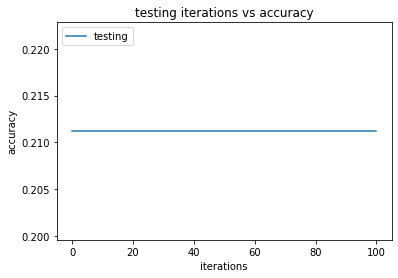

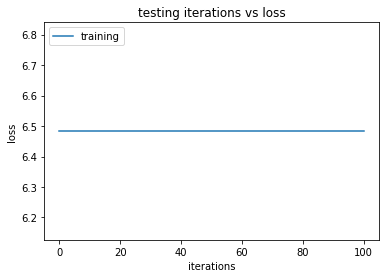

<tf.Tensor: shape=(), dtype=float32, numpy=0.2112>

In [ ]:
test(model, optimizer, loss, num_epochs=1)

In [ ]:
#Q3 Lenet 5 Implementation
#Tensorflow with regularization applied+ opt+ without preprocessing
import tensorflow as tf
from tensorflow.keras.regularizers import l2

class ThreeLayerConvNet(tf.keras.Model):
  def __init__(self, channel_1, channel_2, num_classes, variance=2.0, reg1=None, reg2=None):
    super(ThreeLayerConvNet, self).__init__()

    initializer = tf.initializers.VarianceScaling(scale=variance)
    print('initializer variance')
    print(variance)
    self.conv1 = tf.keras.layers.Conv2D(channel_1, [5,5], [1,1], padding='valid',
                                     kernel_initializer=initializer,
                                     activation=tf.nn.relu)
  
    if reg1 is not None:
      self.conv1 = tf.keras.layers.Conv2D(channel_1, [5,5], [1,1], padding='valid',
                                      kernel_initializer=initializer,
                                      kernel_regularizer=tf.keras.regularizers.l2(reg1),
                                      activation=tf.nn.relu)
      print(reg1)
    self.Pooling1 =tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')
    self.conv2 = tf.keras.layers.Conv2D(channel_2, [3,3], [1,1], padding='valid',
                                     kernel_initializer=initializer,
                                     activation=tf.nn.relu)
    if reg2 is not None:
      self.conv2 = tf.keras.layers.Conv2D(channel_2, [3,3], [1,1], padding='valid',
                                      kernel_initializer=initializer,
                                      kernel_regularizer=tf.keras.regularizers.l2(reg2),
                                      activation=tf.nn.relu)
      print(reg2)
    self.Pooling2 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')
    self.flatten = tf.keras.layers.Flatten()  
    self.fc = tf.keras.layers.Dense(120, kernel_initializer=initializer,activation='tanh')
    self.fc2= tf.keras.layers.Dense(84, activation='tanh')
     
    self.softmax = tf.keras.layers.Softmax()   
    
  def call(self, x, training=False):
    scores = None

    padding = tf.constant([[0,0],[2,2],[2,2],[0,0]])
    x = tf.pad(x, padding, 'CONSTANT')
    x = self.conv1(x)
    x=self.Pooling1(x)
    #padding = tf.constant([[0,0],[1,1],[1,1],[0,0]])
    #x = tf.pad(x, padding, 'CONSTANT')
    x = self.conv2(x)
    x=self.Pooling2(x)
    x = self.flatten(x)
    x = self.fc(x)
    x = self.fc2(x)
    scores = self.softmax(x)
       
    return scores